In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import files
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
# Subo archivo manualmente
uploaded = files.upload()

# Cargo dataset
df = pd.read_csv("fake_job_postings.csv", encoding="utf-8")

# Muestro primeras filas
df.head()


Saving fake_job_postings.csv to fake_job_postings (1).csv


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [6]:
# Elimina columnas irrelevantes
df.drop(columns=['job_id', 'salary_range'], inplace=True)

# Rellena valores nulos con "Desconocido"
df.fillna("Desconocido", inplace=True)

# Convierte variable objetivo a numérica
df['fraudulent'] = df['fraudulent'].astype(int)

# Verifica cambios
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   location             17880 non-null  object
 2   department           17880 non-null  object
 3   company_profile      17880 non-null  object
 4   description          17880 non-null  object
 5   requirements         17880 non-null  object
 6   benefits             17880 non-null  object
 7   telecommuting        17880 non-null  int64 
 8   has_company_logo     17880 non-null  int64 
 9   has_questions        17880 non-null  int64 
 10  employment_type      17880 non-null  object
 11  required_experience  17880 non-null  object
 12  required_education   17880 non-null  object
 13  industry             17880 non-null  object
 14  function             17880 non-null  object
 15  fraudulent           17880 non-null  int64 
dtypes: i

<ipython-input-7-c990dc698737>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['fraudulent'], palette=['blue', 'red'])


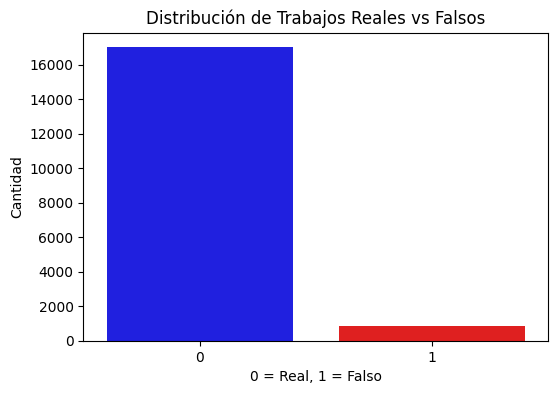

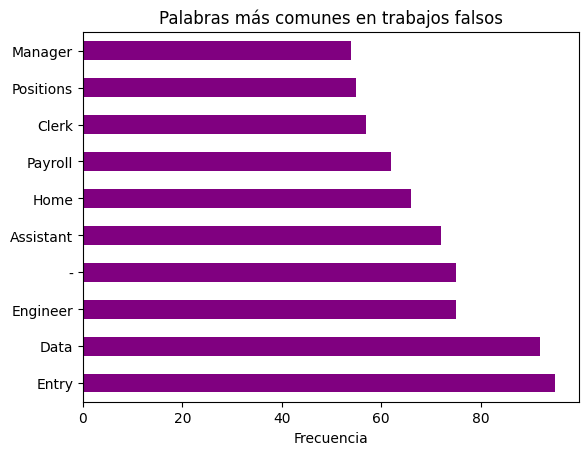

In [7]:
# Visualización de trabajos reales vs falsos
plt.figure(figsize=(6,4))
sns.countplot(x=df['fraudulent'], palette=['blue', 'red'])
plt.title("Distribución de Trabajos Reales vs Falsos")
plt.xlabel("0 = Real, 1 = Falso")
plt.ylabel("Cantidad")
plt.show()

# Palabras más comunes en títulos de trabajos fraudulentos
fake_jobs = df[df['fraudulent'] == 1]['title']
text = ' '.join(fake_jobs)
words = text.split()

# Filtra palabras comunes con stopwords
filtered_words = [word for word in words if word.lower() not in stopwords.words('english')]

# Muestra las 10 palabras más repetidas
pd.Series(filtered_words).value_counts().head(10).plot(kind='barh', color='purple')
plt.title("Palabras más comunes en trabajos falsos")
plt.xlabel("Frecuencia")
plt.show()

# MODELO MACHINE LEARNING

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3395
           1       1.00      0.57      0.73       181

    accuracy                           0.98      3576
   macro avg       0.99      0.79      0.86      3576
weighted avg       0.98      0.98      0.98      3576



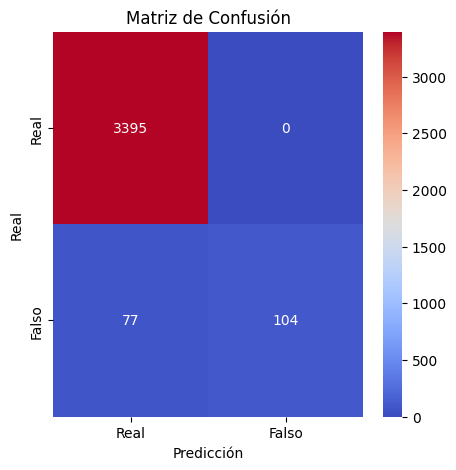

In [8]:
# Prepara los datos
X = df['description']
y = df['fraudulent']

# Transforma texto en características numéricas
vectorizer = TfidfVectorizer(max_features=5000)
X_vectorized = vectorizer.fit_transform(X)

# Dividi en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

# Entrena un modelo RandomForest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluación del modelo
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Matriz de confusión
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="coolwarm", xticklabels=["Real", "Falso"], yticklabels=["Real", "Falso"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()